In [3]:
import cv2
import numpy as np
from skimage import io
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

In [4]:
def plot_img(img, f_size=(10,10)):
    plt.figure(figsize=f_size)
    plt.imshow(img)
    
def plot_gray_img(img, f_size=(10,10)):
    if img.max() <= 1:
        arr = img * 255
    else:
        arr = img.astype(float)
    im = Image.fromarray(arr)
    
    plot_img(im, f_size)
    
PATH = './images/task_1/'

There is no unique parameters which work well for each image so we need to tune it. 

$separate\_text$ function has the next arguments:

$image$ - number of input image

$checkRatio$ - bool parameter if it's required to check square areas to filter images

$th$ - grayscale threshold

$resize$ - image scale value

$iterations$ - dilation iterations

$k\_size$ - kernel size to manipulate the orientation of dilution

In [54]:
def handle_rect(img1, is_dark, is_d, adaptiveTh=(11,5)):
    
    if img1.size == 0:
        return img1
    
#     img2 = cv2.resize(img1, (0,0), fx=1, fy=1) 
    img2 = img1
    
    grayscaled = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
    
    is_black = np.mean(grayscaled) > np.median(grayscaled)
    if (is_black or is_dark) and is_d:
        grayscaled = 255-grayscaled
        pass
    
    threshold = cv2.adaptiveThreshold(grayscaled, 255,
                              cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                              cv2.THRESH_BINARY, adaptiveTh[0], adaptiveTh[1])

#     kernel = np.array([[0,1,0],
#                        [1,1,1],
#                        [0,1,0]], np.uint8)
#     image1 = cv2.dilate(threshold, kernel, iterations=9)
#     image2 = cv2.erode(image1, kernel, iterations=9)

    image3 = cv2.GaussianBlur(threshold,(3,3),0)
    ret, threshold3 = cv2.threshold(image3, 150, 255, cv2.THRESH_BINARY)

    image4 = cv2.fastNlMeansDenoising(threshold3,None,60,7,15)
    
#     image4 = cv2.resize(image4, (0,0), fx=1/2, fy=1/2) 
    
    return image4

def separate_text(image, is_d=True, checkRatio=False, th=150, resize=3, iterations=5, k_size=(11,1), adaptiveTh=(11,5)):
    
    img = cv2.imread(PATH + 'text%s.jpg' % image)
    
    img = cv2.resize(img, (0,0), fx=resize, fy=resize) 
    
    img_final = np.copy(img)
    img2gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(img2gray, th, 255, cv2.THRESH_BINARY)
    image_final = cv2.bitwise_and(img2gray, img2gray, mask=mask)
    
    if is_d:
        is_dark = np.mean(img2gray) < th
    else:
        is_dark = False
    
    # for black text , cv.THRESH_BINARY_INV
    ret, new_img = cv2.threshold(image_final, 0, 255, cv2.THRESH_BINARY if is_dark else cv2.THRESH_BINARY_INV) 
    
    # to manipulate the orientation of dilution,
    # large x means horizonatally dilating  more,
    # large y means vertically dilating more
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, k_size)
    # dilate , more the iteration more the dilation
    dilated = cv2.dilate(new_img, kernel, iterations=iterations)

    # findContours returns 2 variables for getting contours
    contours, hierarchy = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    result = np.full((img.shape[0], img.shape[1]), 255, dtype=np.uint8)
    
    img_cp = np.copy(img)

    for contour in contours:
        # get rectangle bounding contour
        [x, y, w, h] = cv2.boundingRect(contour)

        # Don't plot small false positives that aren't text
        r = float(cv2.countNonZero(mask[y:y+h, x:x+w])) / (w * h)
        if (
            r < 0.45
            or w < 5
            or h < 5
            or (checkRatio and abs(1-w/h) < 0.1)
        ) :
            continue

        # draw rectangle around contour on original image
        cv2.rectangle(img, (x, y), (x + w - 1, y + h - 1), (255, 0, 255), 2)
        
        rect = img_cp[y:y+h-1, x:x+w-1,:]
        result[y:y+h-1, x:x+w-1] = handle_rect(rect, is_dark, is_d, adaptiveTh)

    plot_img(img, (10,10))
    plot_gray_img(result, (20,20))


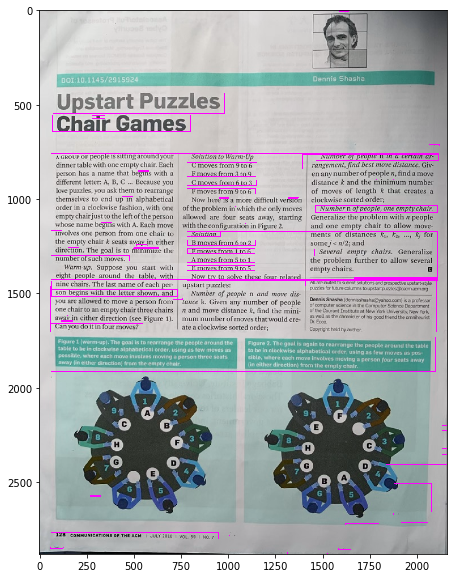

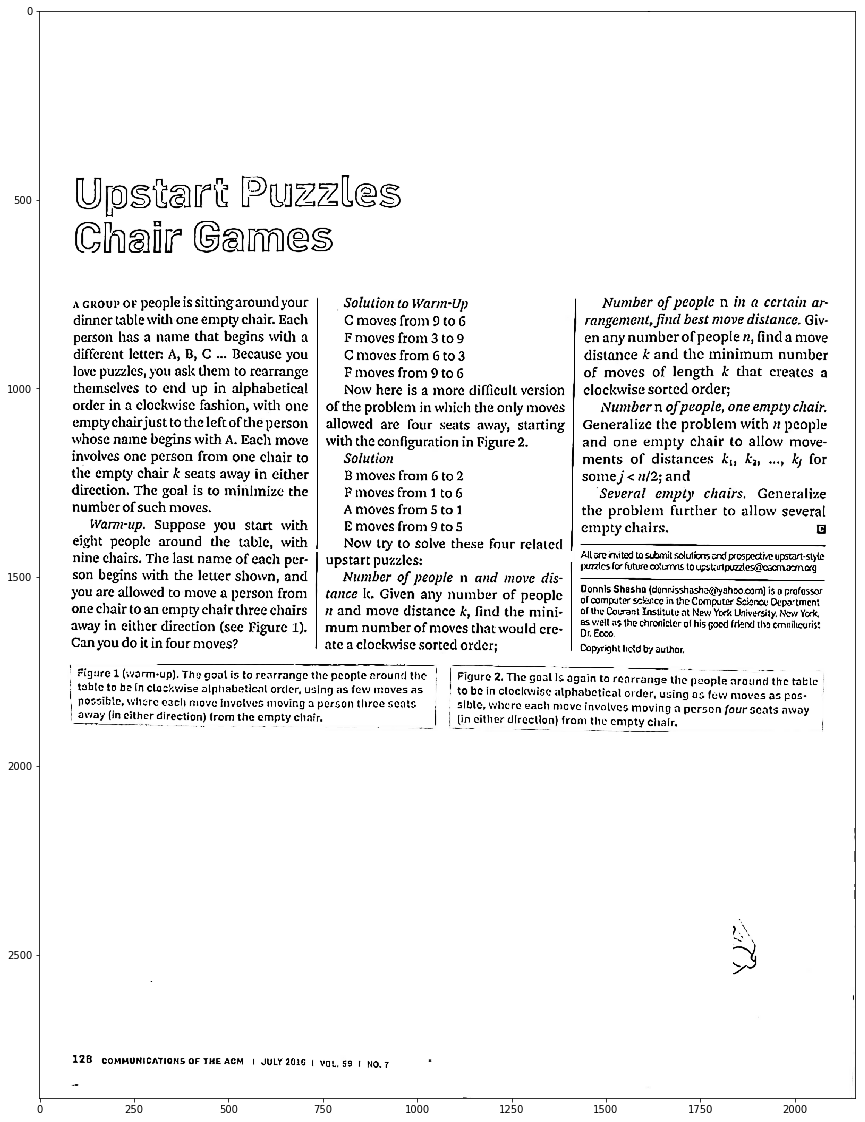

In [55]:
separate_text(1, checkRatio=True)

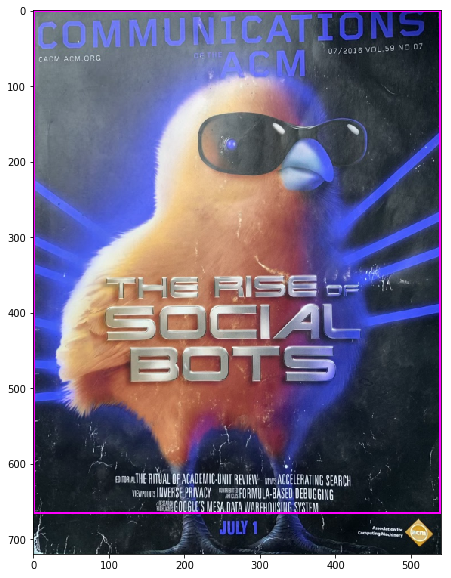

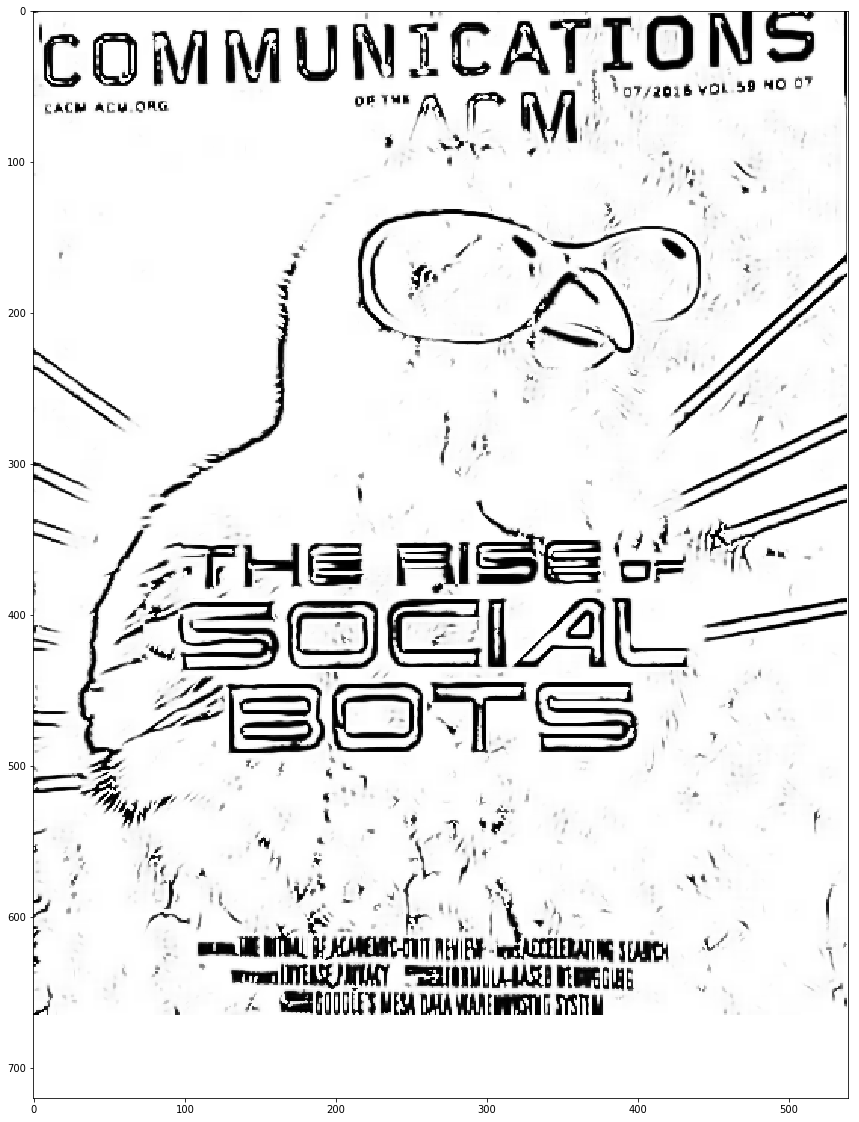

In [56]:
separate_text(2, th=100, resize=0.75)

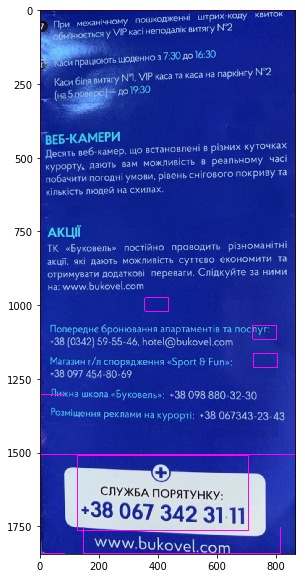

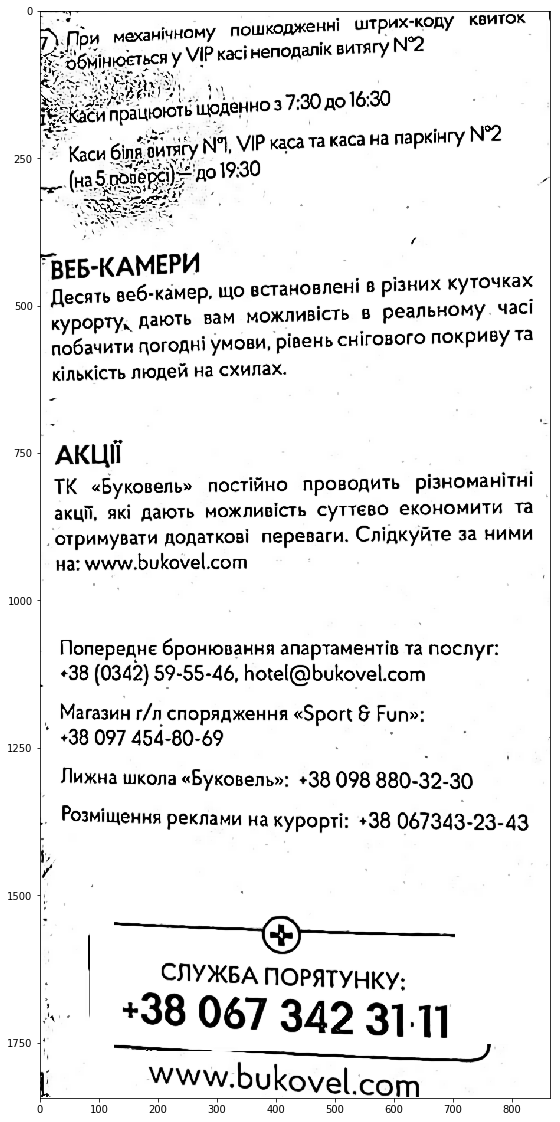

In [77]:
separate_text(3, th=60, resize=2, iterations=9, k_size=(10,6), adaptiveTh=(15, 5))

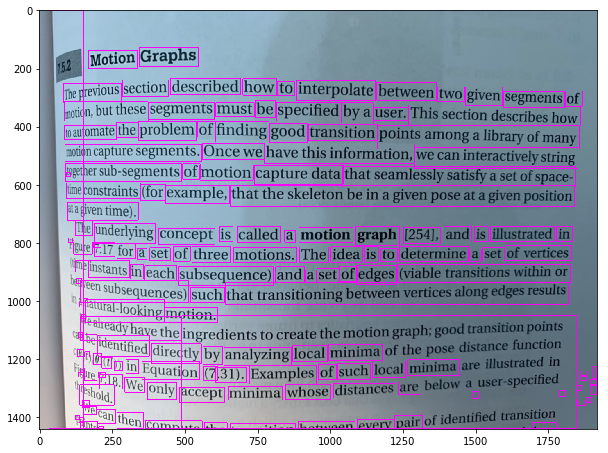

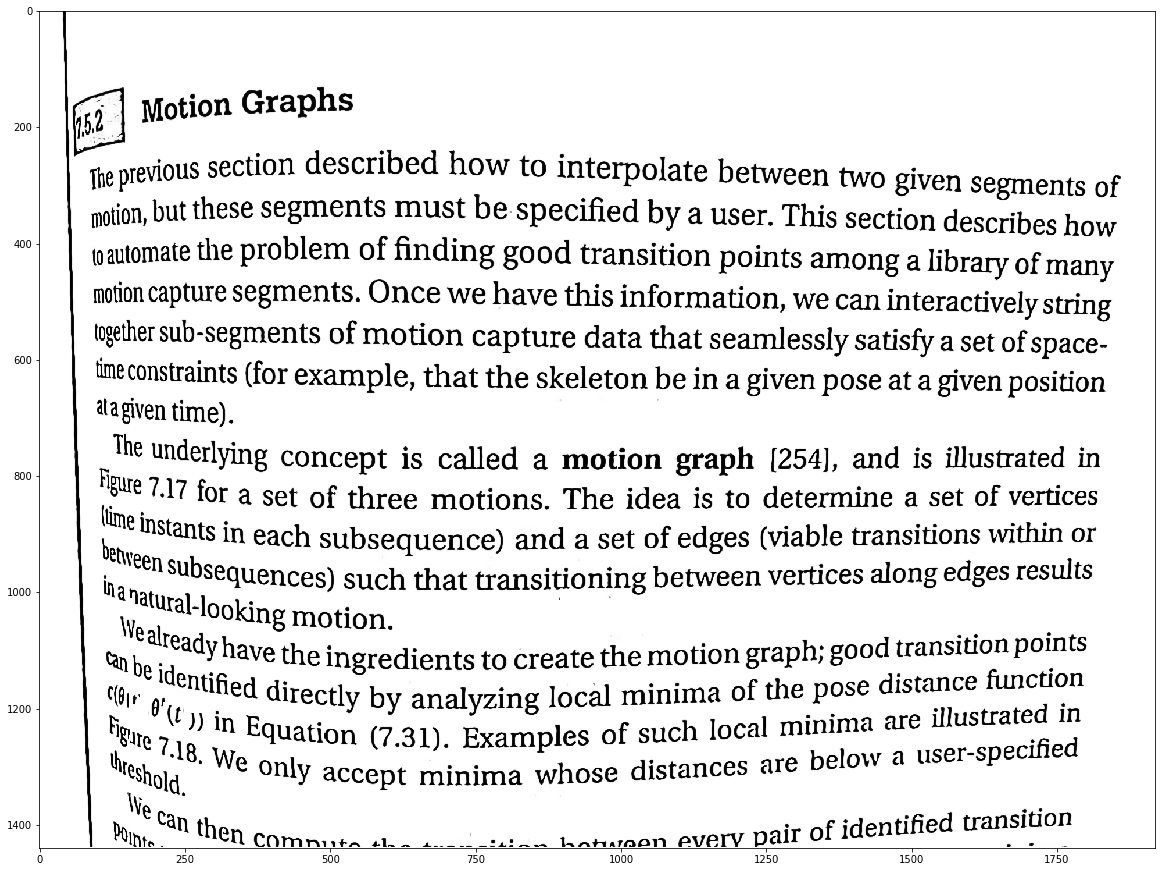

In [58]:
separate_text(4, is_d=False, th=110, resize=2, iterations=3, k_size=(6,6), adaptiveTh=(15,5))

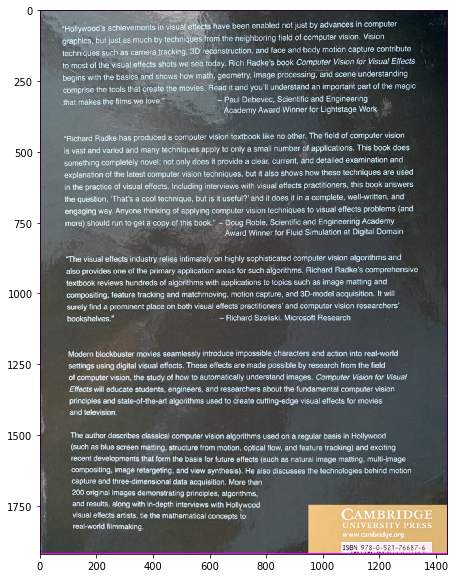

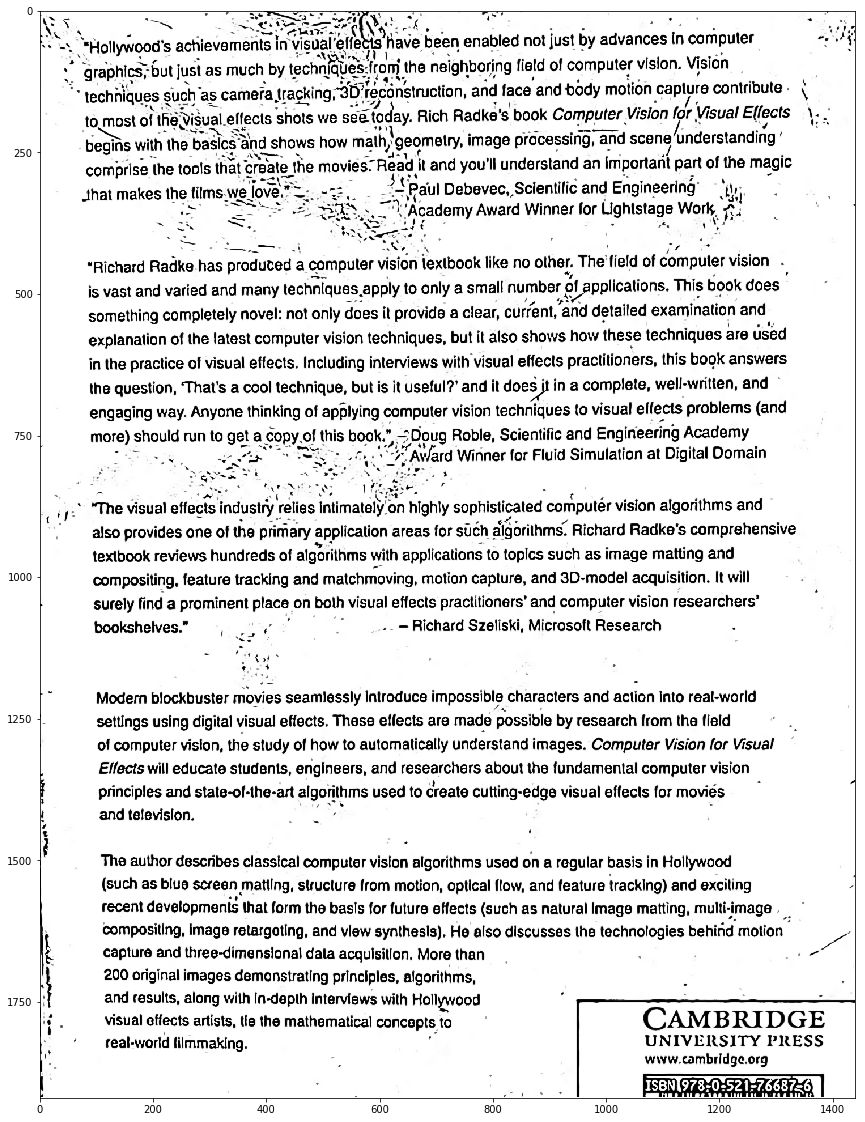

In [64]:
separate_text(5, th=55, resize=2, iterations=40, k_size=(10,6), adaptiveTh=(15,5))

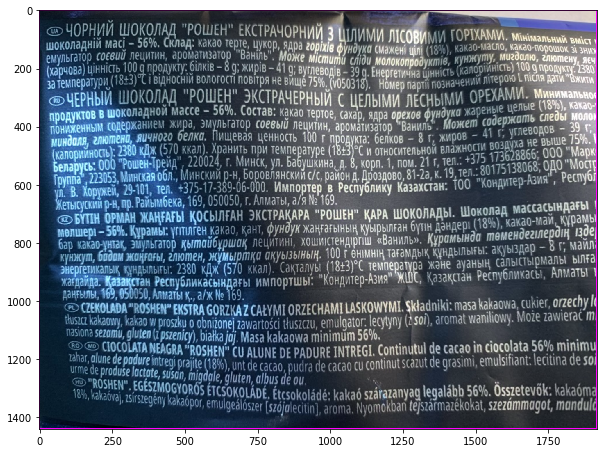

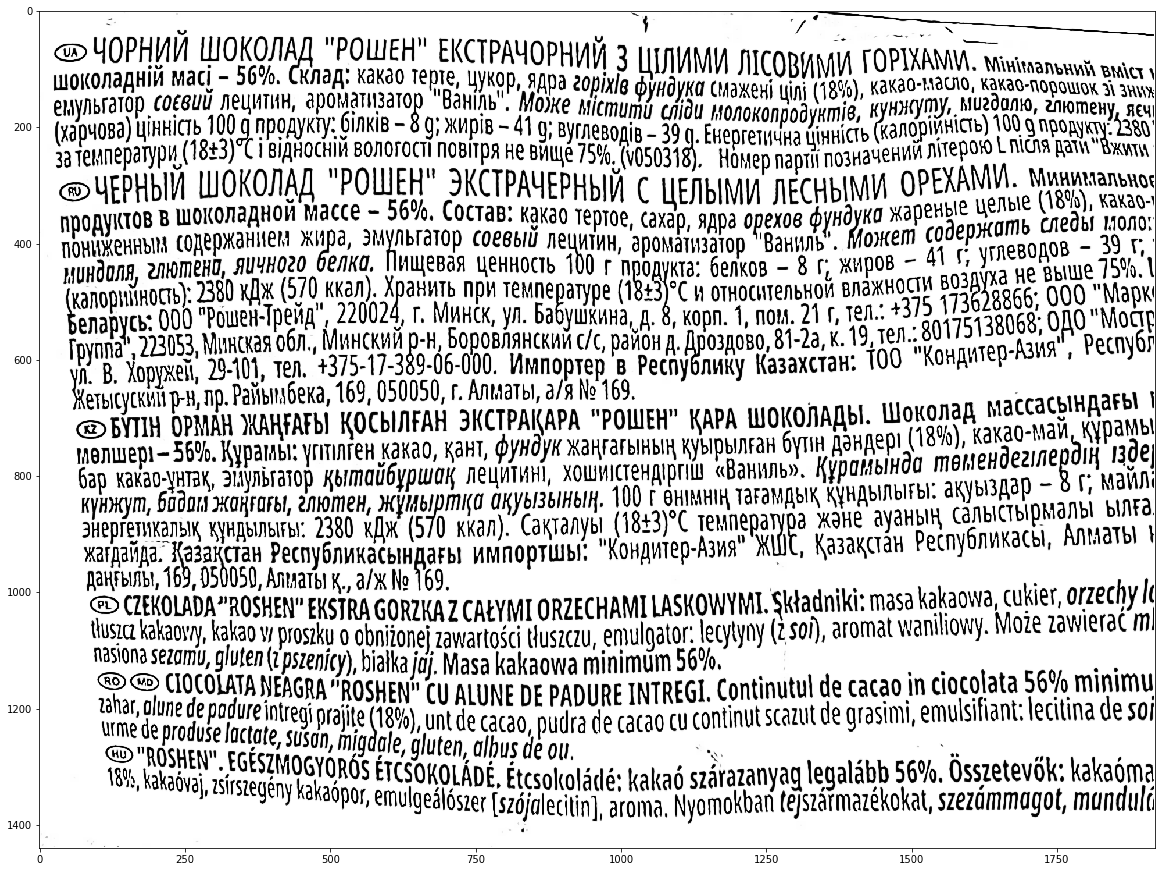

In [72]:
separate_text(6, th=65, resize=2, iterations=5, adaptiveTh=(15, 10))